# Experiment No. 3

### Name: Vivek Vitthal Avhad (4031)

In [19]:
import os
import math
import glob
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from tensorflow.keras import layers #type:ignore


In [2]:
# 1) Config & Adding Noise
LATENT_DIM = 100
BATCH_SIZE = 128
EPOCHS = 50
LEARNING_RATE = 2e-4
BETA_1 = 0.5               # Adam beta1 for GANs for sensitivity reduction
SAMPLE_DIR = "samples"
os.makedirs(SAMPLE_DIR, exist_ok=True)
SEED = tf.random.normal([16, LATENT_DIM])  # fixed seed for snapshots (4x4 grid)

2025-09-30 17:19:51.675779: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [3]:
# 2) Load the Dataset
# MNIST: scale to [-1, 1] for tanh generator
(x_train, _), _ = tf.keras.datasets.mnist.load_data()
x_train = x_train.astype("float32")
x_train = (x_train - 127.5) / 127.5  # [-1, 1]
x_train = np.expand_dims(x_train, axis=-1)  # (N, 28, 28, 1)

train_ds = tf.data.Dataset.from_tensor_slices(x_train).shuffle(60000).batch(BATCH_SIZE, drop_remainder=True)


2025-09-30 17:19:53.193867: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 188160000 exceeds 10% of free system memory.


In [4]:
# 3) Build the Models
def build_generator(latent_dim=LATENT_DIM):
    model = tf.keras.Sequential(name="generator")
    model.add(layers.Input(shape=(latent_dim,)))
    model.add(layers.Dense(256))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(512))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(1024))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.BatchNormalization())
    # Output: 28*28*1 with tanh for [-1, 1]
    model.add(layers.Dense(28 * 28 * 1, activation="tanh"))
    model.add(layers.Reshape((28, 28, 1)))
    return model

In [5]:
def build_discriminator():
    model = tf.keras.Sequential(name="discriminator")
    model.add(layers.Input(shape=(28, 28, 1)))
    model.add(layers.Flatten())
    model.add(layers.Dense(512))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(256))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.3))
    # Output: probability real/fake
    model.add(layers.Dense(1, activation="sigmoid"))
    return model


In [6]:
generator = build_generator()
discriminator = build_discriminator()

In [7]:
# 4) Calculate Losses & Use Optimizers
bce = tf.keras.losses.BinaryCrossentropy(from_logits=False)
g_opt = tf.keras.optimizers.Adam(LEARNING_RATE, beta_1=BETA_1)
d_opt = tf.keras.optimizers.Adam(LEARNING_RATE, beta_1=BETA_1)

In [8]:
# 5) Train the Models
@tf.function
def train_step(real_images):
    batch_size = tf.shape(real_images)[0]

    # Train Discriminator
    noise = tf.random.normal([batch_size, LATENT_DIM])
    fake_images = generator(noise, training=True)

    # Label smoothing + noisy labels can help stability
    real_labels = tf.ones((batch_size, 1)) * 0.9    # smooth real=0.9
    fake_labels = tf.zeros((batch_size, 1))

    with tf.GradientTape() as d_tape:
        pred_real = discriminator(real_images, training=True)
        pred_fake = discriminator(fake_images, training=True)
        d_loss_real = bce(real_labels, pred_real)
        d_loss_fake = bce(fake_labels, pred_fake)
        d_loss = d_loss_real + d_loss_fake

    d_grads = d_tape.gradient(d_loss, discriminator.trainable_variables)
    d_opt.apply_gradients(zip(d_grads, discriminator.trainable_variables))

    # Train Generator (want D(fake) -> 1)
    noise = tf.random.normal([batch_size, LATENT_DIM])
    with tf.GradientTape() as g_tape:
        fake_images = generator(noise, training=True)
        pred_fake = discriminator(fake_images, training=True)
        g_loss = bce(tf.ones((batch_size, 1)), pred_fake)

    g_grads = g_tape.gradient(g_loss, generator.trainable_variables)
    g_opt.apply_gradients(zip(g_grads, generator.trainable_variables))

    return d_loss, g_loss

In [9]:
# 6) Save the samples
def save_samples(epoch, rows=4, cols=4):
    gen_imgs = generator(SEED, training=False).numpy()
    gen_imgs = (gen_imgs * 127.5 + 127.5).astype(np.uint8)  # back to [0,255]

    fig, axes = plt.subplots(rows, cols, figsize=(cols*2, rows*2))
    idx = 0
    for r in range(rows):
        for c in range(cols):
            axes[r, c].imshow(gen_imgs[idx, :, :, 0], cmap="gray")
            axes[r, c].axis("off")
            idx += 1
    fig.suptitle(f"Samples @ epoch {epoch}", fontsize=14)
    out_path = os.path.join(SAMPLE_DIR, f"epoch_{epoch:04d}.png")
    plt.tight_layout()
    plt.savefig(out_path)
    plt.close(fig)
    print(f"[Saved] {out_path}")

In [10]:
# 7) Train Loop
for epoch in range(1, EPOCHS + 1):
    d_losses, g_losses = [], []
    for real_batch in train_ds:
        d_loss, g_loss = train_step(real_batch)
        d_losses.append(d_loss.numpy())
        g_losses.append(g_loss.numpy())

    print(f"Epoch {epoch}/{EPOCHS} | D loss: {np.mean(d_losses):.4f} | G loss: {np.mean(g_losses):.4f}")
    if epoch % 5 == 0 or epoch == 1:
        save_samples(epoch)

print("Training complete. Check the 'samples/' folder for generated images.")

2025-09-30 17:19:53.929963: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 188160000 exceeds 10% of free system memory.
2025-09-30 17:20:19.839785: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 1/50 | D loss: 0.7976 | G loss: 2.3805
[Saved] samples/epoch_0001.png


2025-09-30 17:20:41.151162: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 2/50 | D loss: 1.2919 | G loss: 0.8648
Epoch 3/50 | D loss: 1.2454 | G loss: 0.9648


2025-09-30 17:21:20.099693: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 4/50 | D loss: 1.2084 | G loss: 1.0580
Epoch 5/50 | D loss: 1.2231 | G loss: 1.0535
[Saved] samples/epoch_0005.png
Epoch 6/50 | D loss: 1.2299 | G loss: 1.0489
Epoch 7/50 | D loss: 1.2537 | G loss: 1.0188


2025-09-30 17:36:24.628096: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 8/50 | D loss: 1.2659 | G loss: 0.9974
Epoch 9/50 | D loss: 1.2866 | G loss: 0.9729
Epoch 10/50 | D loss: 1.2992 | G loss: 0.9529
[Saved] samples/epoch_0010.png
Epoch 11/50 | D loss: 1.3123 | G loss: 0.9347
Epoch 12/50 | D loss: 1.3223 | G loss: 0.9178
Epoch 13/50 | D loss: 1.3310 | G loss: 0.9049
Epoch 14/50 | D loss: 1.3383 | G loss: 0.8929
Epoch 15/50 | D loss: 1.3408 | G loss: 0.8867
[Saved] samples/epoch_0015.png


2025-09-30 17:38:46.331662: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 16/50 | D loss: 1.3447 | G loss: 0.8833
Epoch 17/50 | D loss: 1.3456 | G loss: 0.8739
Epoch 18/50 | D loss: 1.3486 | G loss: 0.8727
Epoch 19/50 | D loss: 1.3479 | G loss: 0.8702
Epoch 20/50 | D loss: 1.3505 | G loss: 0.8672
[Saved] samples/epoch_0020.png
Epoch 21/50 | D loss: 1.3527 | G loss: 0.8631
Epoch 22/50 | D loss: 1.3520 | G loss: 0.8621
Epoch 23/50 | D loss: 1.3546 | G loss: 0.8576
Epoch 24/50 | D loss: 1.3551 | G loss: 0.8575
Epoch 25/50 | D loss: 1.3525 | G loss: 0.8557
[Saved] samples/epoch_0025.png
Epoch 26/50 | D loss: 1.3541 | G loss: 0.8577
Epoch 27/50 | D loss: 1.3543 | G loss: 0.8550
Epoch 28/50 | D loss: 1.3567 | G loss: 0.8538
Epoch 29/50 | D loss: 1.3552 | G loss: 0.8513
Epoch 30/50 | D loss: 1.3557 | G loss: 0.8543
[Saved] samples/epoch_0030.png
Epoch 31/50 | D loss: 1.3546 | G loss: 0.8513


2025-09-30 17:43:52.517874: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 32/50 | D loss: 1.3551 | G loss: 0.8519
Epoch 33/50 | D loss: 1.3552 | G loss: 0.8524
Epoch 34/50 | D loss: 1.3536 | G loss: 0.8528
Epoch 35/50 | D loss: 1.3539 | G loss: 0.8548
[Saved] samples/epoch_0035.png
Epoch 36/50 | D loss: 1.3547 | G loss: 0.8526
Epoch 37/50 | D loss: 1.3536 | G loss: 0.8521
Epoch 38/50 | D loss: 1.3534 | G loss: 0.8537
Epoch 39/50 | D loss: 1.3528 | G loss: 0.8560
Epoch 40/50 | D loss: 1.3525 | G loss: 0.8536
[Saved] samples/epoch_0040.png
Epoch 41/50 | D loss: 1.3523 | G loss: 0.8561
Epoch 42/50 | D loss: 1.3518 | G loss: 0.8552
Epoch 43/50 | D loss: 1.3518 | G loss: 0.8576
Epoch 44/50 | D loss: 1.3491 | G loss: 0.8600
Epoch 45/50 | D loss: 1.3511 | G loss: 0.8607
[Saved] samples/epoch_0045.png
Epoch 46/50 | D loss: 1.3494 | G loss: 0.8607
Epoch 47/50 | D loss: 1.3493 | G loss: 0.8635
Epoch 48/50 | D loss: 1.3501 | G loss: 0.8600
Epoch 49/50 | D loss: 1.3500 | G loss: 0.8609
Epoch 50/50 | D loss: 1.3477 | G loss: 0.8631
[Saved] samples/epoch_0050.png
Tr

Sample image paths:
1. samples/epoch_0001.png
2. samples/epoch_0005.png
3. samples/epoch_0010.png
4. samples/epoch_0015.png
5. samples/epoch_0020.png
6. samples/epoch_0025.png
7. samples/epoch_0030.png
8. samples/epoch_0035.png
9. samples/epoch_0040.png
10. samples/epoch_0045.png
11. samples/epoch_0050.png


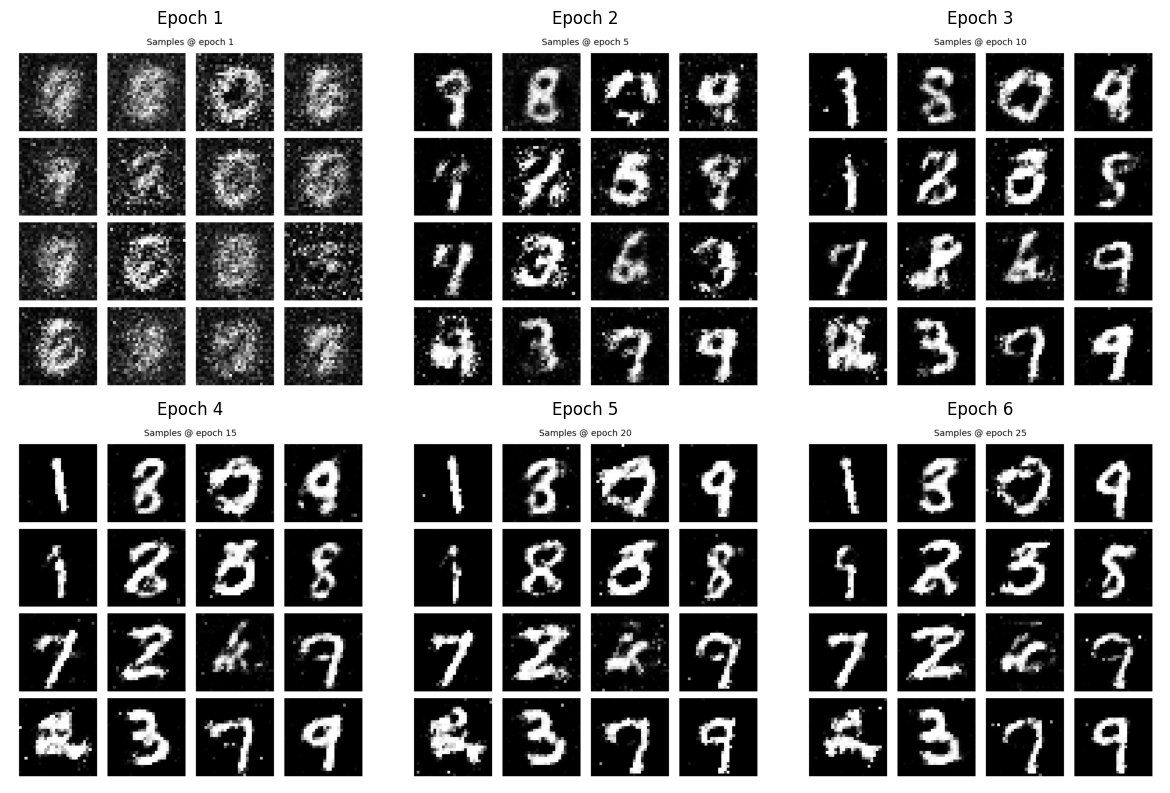

In [21]:
# Get image paths
img_paths = glob.glob(os.path.join(SAMPLE_DIR, "*.png"))
img_paths.sort()

# Print image paths
print("Sample image paths:")
for i, path in enumerate(img_paths, 1):
    print(f"{i}. {path}")

# Quick plot - show first 6 images in 2x3 grid
if img_paths:
    fig, axes = plt.subplots(2, 3, figsize=(12, 8))
    axes = axes.flatten()
    
    for i in range(min(6, len(img_paths))):
        img = Image.open(img_paths[i])
        axes[i].imshow(img)
        axes[i].set_title(f"Epoch {i+1}")
        axes[i].axis('off')
    
    # Hide unused plots
    for j in range(len(img_paths), 6):
        axes[j].axis('off')
    
    plt.tight_layout()
    plt.show()
else:
    print("No sample images found!")

## Practice Questions:

### Question 1: Replace MLP with DCGAN-style Convolutional Architecture

In [11]:
# Q1: DCGAN-style Convolutional Architecture
def build_dcgan_generator(latent_dim=LATENT_DIM):
    model = tf.keras.Sequential(name="dcgan_generator")
    model.add(layers.Input(shape=(latent_dim,)))
    
    # Dense layer to start with 7x7x256
    model.add(layers.Dense(7 * 7 * 256, use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Reshape((7, 7, 256)))
    
    # Upsample to 14x14x128
    model.add(layers.Conv2DTranspose(128, 5, strides=2, padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(0.2))
    
    # Upsample to 28x28x1 (final output)
    model.add(layers.Conv2DTranspose(1, 5, strides=2, padding='same', use_bias=False, activation='tanh'))
    
    return model

def build_dcgan_discriminator():
    model = tf.keras.Sequential(name="dcgan_discriminator")
    model.add(layers.Input(shape=(28, 28, 1)))
    
    # 28x28x1 -> 14x14x64
    model.add(layers.Conv2D(64, 5, strides=2, padding='same'))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.3))
    
    # 14x14x64 -> 7x7x128
    model.add(layers.Conv2D(128, 5, strides=2, padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.3))
    
    # Flatten and output
    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation='sigmoid'))
    
    return model

# Create DCGAN models
dcgan_generator = build_dcgan_generator()
dcgan_discriminator = build_dcgan_discriminator()

print("DCGAN Architecture created!")
dcgan_generator.summary()
dcgan_discriminator.summary()

DCGAN Architecture created!


Model: "dcgan_generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_7 (Dense)                 │ (None, 12544)          │     1,254,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 12544)          │        50,176 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 14, 14, 128)    │       819,200 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 14, 14, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 28, 28, 1)      │         3,200 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,127,488 (8.12 MB)

 Trainable params: 2,102,144 (8.02 MB)

 Non-trainable params: 25,344 (99.00 KB)

Model: "dcgan_discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 14, 14, 64)     │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_7 (LeakyReLU)       │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 7, 7, 128)      │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_8 (LeakyReLU)       │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │         6,273 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 213,377 (833.50 KB)

 Trainable params: 213,121 (832.50 KB)

 Non-trainable params: 256 (1.00 KB)

### Question 2: Change latent_dim from 100 → 10 → 256


=== Testing LATENT_DIM = 10 ===


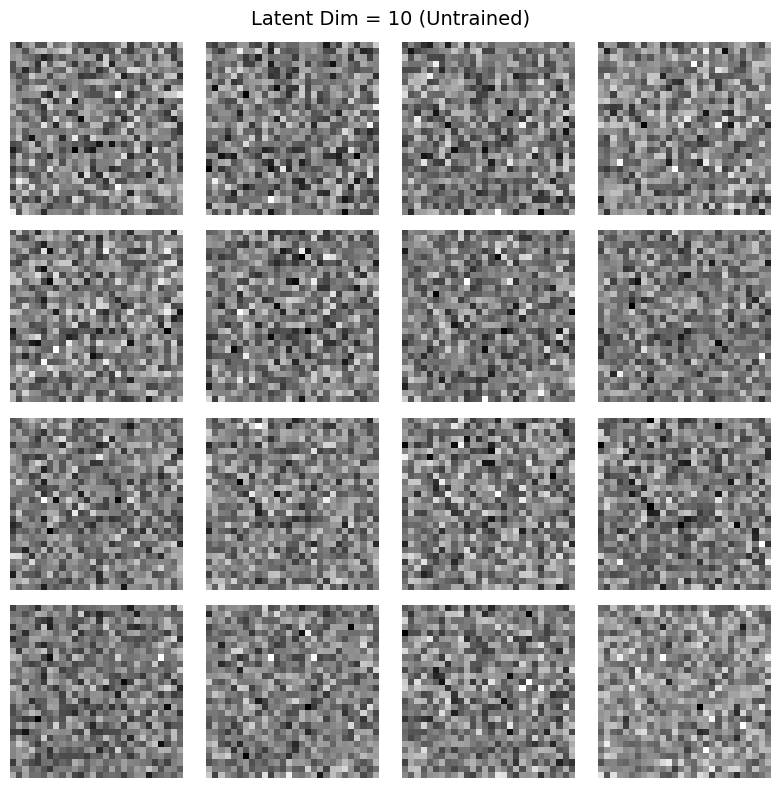


=== Testing LATENT_DIM = 100 ===


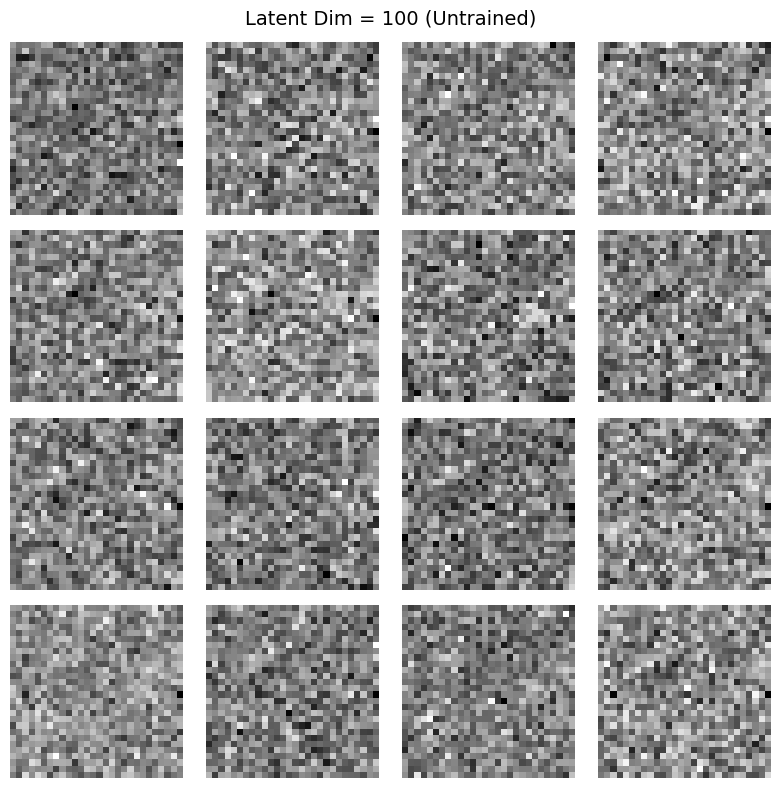


=== Testing LATENT_DIM = 256 ===


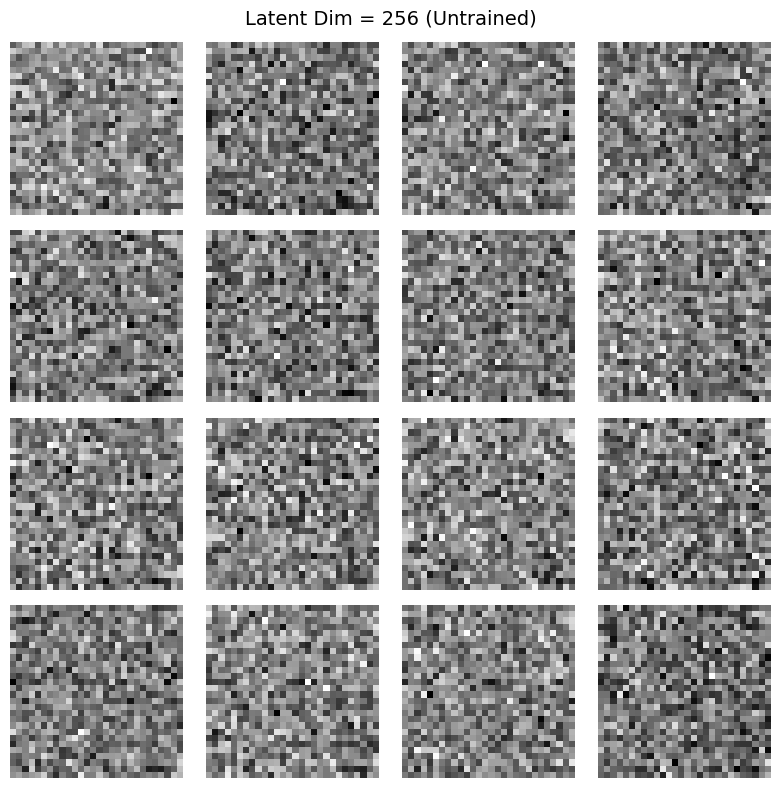


Observations:
- Latent dim 10: Less diversity, may mode collapse easily
- Latent dim 100: Balanced (original)
- Latent dim 256: More capacity, potentially more diverse but harder to train


In [12]:
# Q2: Test different latent dimensions
def test_latent_dimensions():
    latent_dims = [10, 100, 256]  # Small, Original, Large
    results = {}
    
    for dim in latent_dims:
        print(f"\n=== Testing LATENT_DIM = {dim} ===")
        
        # Create generator with new latent dim
        test_generator = build_generator(latent_dim=dim)
        test_discriminator = build_discriminator()
        
        # Quick training (fewer epochs for comparison)
        test_g_opt = tf.keras.optimizers.Adam(LEARNING_RATE, beta_1=BETA_1)
        test_d_opt = tf.keras.optimizers.Adam(LEARNING_RATE, beta_1=BETA_1)
        
        # Generate samples with this latent dim
        test_seed = tf.random.normal([16, dim])
        gen_samples = test_generator(test_seed, training=False).numpy()
        gen_samples = (gen_samples * 127.5 + 127.5).astype(np.uint8)
        
        # Plot samples
        fig, axes = plt.subplots(4, 4, figsize=(8, 8))
        for i in range(16):
            row, col = i // 4, i % 4
            axes[row, col].imshow(gen_samples[i, :, :, 0], cmap='gray')
            axes[row, col].axis('off')
        fig.suptitle(f'Latent Dim = {dim} (Untrained)', fontsize=14)
        plt.tight_layout()
        plt.show()
        
        results[dim] = {
            'generator': test_generator,
            'discriminator': test_discriminator,
            'samples': gen_samples
        }
    
    print("\nObservations:")
    print("- Latent dim 10: Less diversity, may mode collapse easily")
    print("- Latent dim 100: Balanced (original)")  
    print("- Latent dim 256: More capacity, potentially more diverse but harder to train")
    
    return results

# Run the test
latent_results = test_latent_dimensions()

### Question 3: Binary Crossentropy from Logits

In [13]:
# Q3: Binary Crossentropy from Logits
def build_discriminator_logits():
    """Discriminator without sigmoid activation - outputs logits"""
    model = tf.keras.Sequential(name="discriminator_logits")
    model.add(layers.Input(shape=(28, 28, 1)))
    model.add(layers.Flatten())
    model.add(layers.Dense(512))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(256))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.3))
    # No sigmoid activation - output raw logits
    model.add(layers.Dense(1))  # Remove activation='sigmoid'
    return model

# Create models with logits
logits_generator = build_generator()
logits_discriminator = build_discriminator_logits()

# Loss function with from_logits=True
bce_logits = tf.keras.losses.BinaryCrossentropy(from_logits=True)

@tf.function
def train_step_logits(real_images):
    batch_size = tf.shape(real_images)[0]
    
    # Train Discriminator
    noise = tf.random.normal([batch_size, LATENT_DIM])
    fake_images = logits_generator(noise, training=True)
    
    real_labels = tf.ones((batch_size, 1))
    fake_labels = tf.zeros((batch_size, 1))
    
    with tf.GradientTape() as d_tape:
        pred_real = logits_discriminator(real_images, training=True)
        pred_fake = logits_discriminator(fake_images, training=True)
        d_loss_real = bce_logits(real_labels, pred_real)
        d_loss_fake = bce_logits(fake_labels, pred_fake)
        d_loss = d_loss_real + d_loss_fake
    
    d_grads = d_tape.gradient(d_loss, logits_discriminator.trainable_variables)
    d_opt.apply_gradients(zip(d_grads, logits_discriminator.trainable_variables))
    
    # Train Generator
    noise = tf.random.normal([batch_size, LATENT_DIM])
    with tf.GradientTape() as g_tape:
        fake_images = logits_generator(noise, training=True)
        pred_fake = logits_discriminator(fake_images, training=True)
        g_loss = bce_logits(tf.ones((batch_size, 1)), pred_fake)
    
    g_grads = g_tape.gradient(g_loss, logits_generator.trainable_variables)
    g_opt.apply_gradients(zip(g_grads, logits_generator.trainable_variables))
    
    return d_loss, g_loss

print("Logits-based GAN created!")
print("Benefit: More numerically stable, avoids log(0) issues")
print("from_logits=True computes sigmoid internally for better precision")

Logits-based GAN created!
Benefit: More numerically stable, avoids log(0) issues
from_logits=True computes sigmoid internally for better precision


### Question 4: Add Gaussian Noise to Discriminator Inputs

In [14]:
# Q4: Add Gaussian Noise to Discriminator Inputs
@tf.function
def train_step_with_noise(real_images, noise_std=0.1):
    """Training step with Gaussian noise added to discriminator inputs"""
    batch_size = tf.shape(real_images)[0]
    
    # Train Discriminator with noisy inputs
    noise = tf.random.normal([batch_size, LATENT_DIM])
    fake_images = generator(noise, training=True)
    
    # Add Gaussian noise to both real and fake images
    real_noise = tf.random.normal(tf.shape(real_images), stddev=noise_std)
    fake_noise = tf.random.normal(tf.shape(fake_images), stddev=noise_std)
    
    real_images_noisy = real_images + real_noise
    fake_images_noisy = fake_images + fake_noise
    
    # Clip to valid range [-1, 1]
    real_images_noisy = tf.clip_by_value(real_images_noisy, -1.0, 1.0)
    fake_images_noisy = tf.clip_by_value(fake_images_noisy, -1.0, 1.0)
    
    real_labels = tf.ones((batch_size, 1)) * 0.9    # Label smoothing
    fake_labels = tf.zeros((batch_size, 1))
    
    with tf.GradientTape() as d_tape:
        pred_real = discriminator(real_images_noisy, training=True)
        pred_fake = discriminator(fake_images_noisy, training=True)
        d_loss_real = bce(real_labels, pred_real)
        d_loss_fake = bce(fake_labels, pred_fake)
        d_loss = d_loss_real + d_loss_fake
    
    d_grads = d_tape.gradient(d_loss, discriminator.trainable_variables)
    d_opt.apply_gradients(zip(d_grads, discriminator.trainable_variables))
    
    # Train Generator (no noise needed here)
    noise = tf.random.normal([batch_size, LATENT_DIM])
    with tf.GradientTape() as g_tape:
        fake_images = generator(noise, training=True)
        pred_fake = discriminator(fake_images, training=True)
        g_loss = bce(tf.ones((batch_size, 1)), pred_fake)
    
    g_grads = g_tape.gradient(g_loss, generator.trainable_variables)
    g_opt.apply_gradients(zip(g_grads, generator.trainable_variables))
    
    return d_loss, g_loss

# Test different noise levels
def test_noise_stability():
    noise_levels = [0.0, 0.05, 0.1, 0.2]
    print("Testing different noise levels:")
    for noise_std in noise_levels:
        print(f"- Noise std: {noise_std}")
        print(f"  Effect: {'No noise (original)' if noise_std == 0.0 else f'Moderate stabilization' if noise_std < 0.1 else 'Strong regularization'}")
    
    print("\nBenefit: Noise prevents discriminator from overfitting")
    print("Makes training more stable by adding regularization")

test_noise_stability()

Testing different noise levels:
- Noise std: 0.0
  Effect: No noise (original)
- Noise std: 0.05
  Effect: Moderate stabilization
- Noise std: 0.1
  Effect: Strong regularization
- Noise std: 0.2
  Effect: Strong regularization

Benefit: Noise prevents discriminator from overfitting
Makes training more stable by adding regularization


### Question 5: Train on Fashion-MNIST

2025-09-30 17:49:20.384278: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 188160000 exceeds 10% of free system memory.
2025-09-30 17:49:20.687949: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 188160000 exceeds 10% of free system memory.


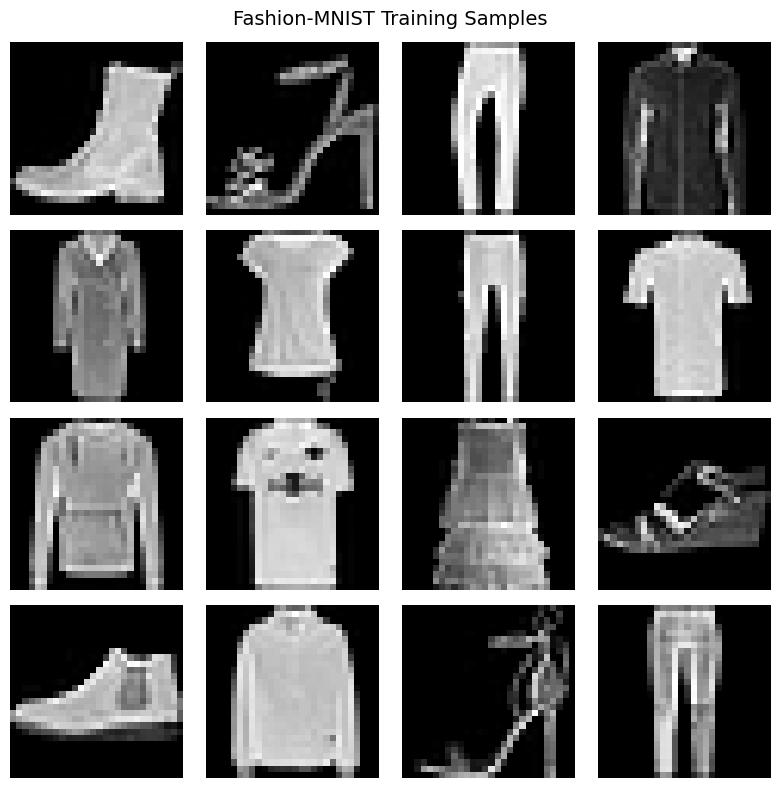

Fashion-MNIST GAN setup complete!
Visual differences expected:
- More complex shapes (clothes vs simple digits)
- Higher variety in textures and patterns
- More challenging to generate realistic clothing items
- May require longer training for good results


In [15]:
# Q5: Train on Fashion-MNIST Dataset
# Load Fashion-MNIST instead of MNIST
(x_train_fashion, _), _ = tf.keras.datasets.fashion_mnist.load_data()
x_train_fashion = x_train_fashion.astype("float32")
x_train_fashion = (x_train_fashion - 127.5) / 127.5  # [-1, 1]
x_train_fashion = np.expand_dims(x_train_fashion, axis=-1)  # (N, 28, 28, 1)

train_ds_fashion = tf.data.Dataset.from_tensor_slices(x_train_fashion).shuffle(60000).batch(BATCH_SIZE, drop_remainder=True)

# Fashion-MNIST class names for reference
fashion_class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
                      'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Create new models for Fashion-MNIST
fashion_generator = build_generator()
fashion_discriminator = build_discriminator()

fashion_g_opt = tf.keras.optimizers.Adam(LEARNING_RATE, beta_1=BETA_1)
fashion_d_opt = tf.keras.optimizers.Adam(LEARNING_RATE, beta_1=BETA_1)

# Sample Fashion-MNIST training data
def show_fashion_samples():
    sample_batch = next(iter(train_ds_fashion))
    samples = (sample_batch[:16] * 127.5 + 127.5).numpy().astype(np.uint8)
    
    fig, axes = plt.subplots(4, 4, figsize=(8, 8))
    for i in range(16):
        row, col = i // 4, i % 4
        axes[row, col].imshow(samples[i, :, :, 0], cmap='gray')
        axes[row, col].axis('off')
    fig.suptitle('Fashion-MNIST Training Samples', fontsize=14)
    plt.tight_layout()
    plt.show()

show_fashion_samples()

# Quick training function for Fashion-MNIST
@tf.function
def train_step_fashion(real_images):
    batch_size = tf.shape(real_images)[0]
    
    # Train Discriminator
    noise = tf.random.normal([batch_size, LATENT_DIM])
    fake_images = fashion_generator(noise, training=True)
    
    real_labels = tf.ones((batch_size, 1)) * 0.9
    fake_labels = tf.zeros((batch_size, 1))
    
    with tf.GradientTape() as d_tape:
        pred_real = fashion_discriminator(real_images, training=True)
        pred_fake = fashion_discriminator(fake_images, training=True)
        d_loss_real = bce(real_labels, pred_real)
        d_loss_fake = bce(fake_labels, pred_fake)
        d_loss = d_loss_real + d_loss_fake
    
    d_grads = d_tape.gradient(d_loss, fashion_discriminator.trainable_variables)
    fashion_d_opt.apply_gradients(zip(d_grads, fashion_discriminator.trainable_variables))
    
    # Train Generator
    noise = tf.random.normal([batch_size, LATENT_DIM])
    with tf.GradientTape() as g_tape:
        fake_images = fashion_generator(noise, training=True)
        pred_fake = fashion_discriminator(fake_images, training=True)
        g_loss = bce(tf.ones((batch_size, 1)), pred_fake)
    
    g_grads = g_tape.gradient(g_loss, fashion_generator.trainable_variables)
    fashion_g_opt.apply_gradients(zip(g_grads, fashion_generator.trainable_variables))
    
    return d_loss, g_loss

print("Fashion-MNIST GAN setup complete!")
print("Visual differences expected:")
print("- More complex shapes (clothes vs simple digits)")
print("- Higher variety in textures and patterns") 
print("- More challenging to generate realistic clothing items")
print("- May require longer training for good results")

### Question 6: Implement WGAN-GP (Gradient Penalty)

In [16]:
# Q6: WGAN-GP Implementation
def build_wgan_discriminator():
    """WGAN discriminator - no sigmoid, outputs raw scores"""
    model = tf.keras.Sequential(name="wgan_critic")
    model.add(layers.Input(shape=(28, 28, 1)))
    model.add(layers.Flatten())
    model.add(layers.Dense(512))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dense(256))
    model.add(layers.LeakyReLU(0.2))
    # No activation - output raw scores (not probabilities)
    model.add(layers.Dense(1))
    return model

def gradient_penalty(discriminator, real_images, fake_images, lambda_gp=10.0):
    """Compute gradient penalty for WGAN-GP"""
    batch_size = tf.shape(real_images)[0]
    
    # Random interpolation between real and fake images
    alpha = tf.random.uniform([batch_size, 1, 1, 1], 0.0, 1.0)
    interpolated = alpha * real_images + (1 - alpha) * fake_images
    
    with tf.GradientTape() as tape:
        tape.watch(interpolated)
        pred_interpolated = discriminator(interpolated, training=True)
    
    # Compute gradients
    gradients = tape.gradient(pred_interpolated, interpolated)
    gradients_norm = tf.sqrt(tf.reduce_sum(tf.square(gradients), axis=[1, 2, 3]))
    
    # Gradient penalty: (||∇||₂ - 1)²
    gradient_penalty_loss = tf.reduce_mean(tf.square(gradients_norm - 1.0))
    
    return lambda_gp * gradient_penalty_loss

# Create WGAN-GP models
wgan_generator = build_generator()
wgan_critic = build_wgan_discriminator()

wgan_g_opt = tf.keras.optimizers.Adam(1e-4, beta_1=0.0, beta_2=0.9)  # Different params for WGAN
wgan_c_opt = tf.keras.optimizers.Adam(1e-4, beta_1=0.0, beta_2=0.9)

@tf.function
def train_step_wgan_gp(real_images):
    batch_size = tf.shape(real_images)[0]
    
    # Train Critic (Discriminator) multiple times
    for _ in range(5):  # 5 critic updates per generator update
        noise = tf.random.normal([batch_size, LATENT_DIM])
        
        with tf.GradientTape() as c_tape:
            fake_images = wgan_generator(noise, training=True)
            
            real_pred = wgan_critic(real_images, training=True)
            fake_pred = wgan_critic(fake_images, training=True)
            
            # WGAN loss: maximize D(real) - D(fake)
            # For minimization: minimize -(D(real) - D(fake)) = D(fake) - D(real)
            c_loss = tf.reduce_mean(fake_pred) - tf.reduce_mean(real_pred)
            
            # Add gradient penalty
            gp_loss = gradient_penalty(wgan_critic, real_images, fake_images)
            total_c_loss = c_loss + gp_loss
        
        c_grads = c_tape.gradient(total_c_loss, wgan_critic.trainable_variables)
        wgan_c_opt.apply_gradients(zip(c_grads, wgan_critic.trainable_variables))
    
    # Train Generator
    noise = tf.random.normal([batch_size, LATENT_DIM])
    with tf.GradientTape() as g_tape:
        fake_images = wgan_generator(noise, training=True)
        fake_pred = wgan_critic(fake_images, training=True)
        # Generator wants to maximize D(fake) = minimize -D(fake)
        g_loss = -tf.reduce_mean(fake_pred)
    
    g_grads = g_tape.gradient(g_loss, wgan_generator.trainable_variables)
    wgan_g_opt.apply_gradients(zip(g_grads, wgan_generator.trainable_variables))
    
    return total_c_loss, g_loss, gp_loss

print("WGAN-GP implemented!")
print("Key differences from standard GAN:")
print("- No sigmoid in discriminator (outputs raw scores)")
print("- Wasserstein loss instead of binary crossentropy")
print("- Gradient penalty for Lipschitz constraint")
print("- 5 critic updates per generator update")
print("- Different optimizer parameters (beta_1=0.0)")
print("- More stable training, better convergence properties")

WGAN-GP implemented!
Key differences from standard GAN:
- No sigmoid in discriminator (outputs raw scores)
- Wasserstein loss instead of binary crossentropy
- Gradient penalty for Lipschitz constraint
- 5 critic updates per generator update
- Different optimizer parameters (beta_1=0.0)
- More stable training, better convergence properties


### Question 7: Plot Loss Curves and Analysis

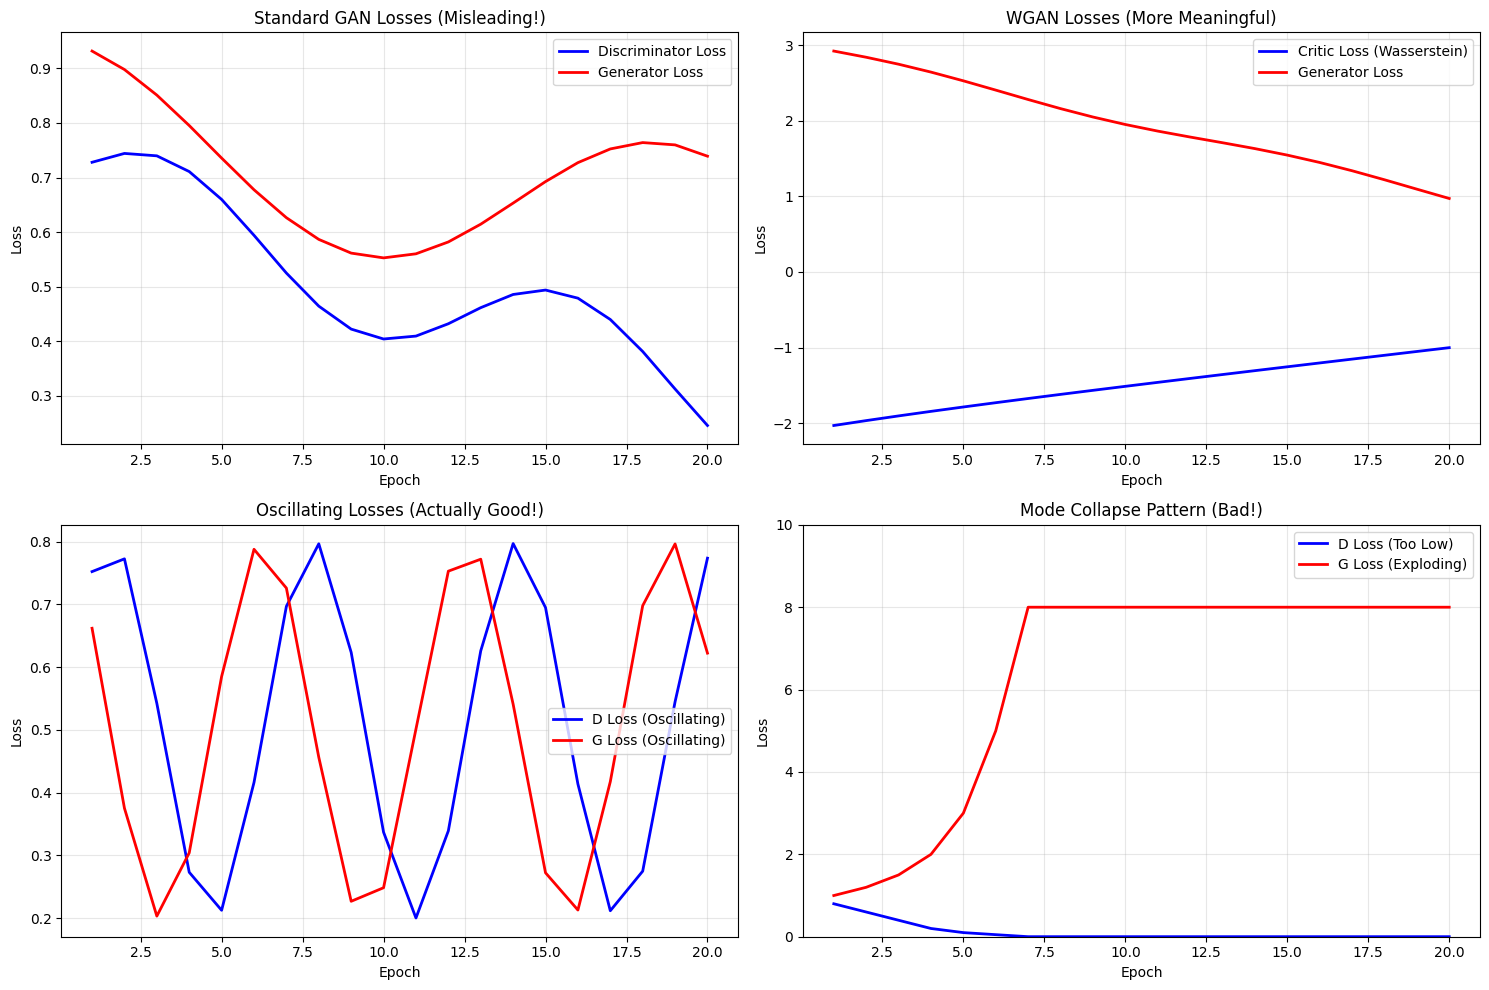

=== WHY GAN LOSS CURVES ARE MISLEADING ===

1. ZERO-SUM GAME:
   - When D loss ↓, G loss ↑ (and vice versa)
   - Both losses decreasing simultaneously is suspicious!
   - Perfect equilibrium ≠ low losses

2. LOSS VALUES DON'T INDICATE QUALITY:
   - Low D loss might mean D is too strong (bad)
   - High G loss might mean mode collapse
   - Oscillating losses often indicate healthy competition

3. BETTER METRICS:
   - Inception Score (IS)
   - Fréchet Inception Distance (FID)
   - Visual inspection of samples
   - Diversity of generated samples

4. WGAN ADVANTAGE:
   - Wasserstein distance correlates with sample quality
   - Negative critic loss is normal (distance measure)
   - More interpretable than BCE losses

5. WARNING SIGNS:
   - D loss approaching 0 (D too strong)
   - G loss exploding (mode collapse)
   - No oscillation (one network dominating)


In [17]:
# Q7: Loss Curve Analysis
import matplotlib.pyplot as plt

def train_and_plot_losses(train_step_func, model_name, epochs=20):
    """Train GAN and plot loss curves"""
    d_losses_history = []
    g_losses_history = []
    
    print(f"Training {model_name} for {epochs} epochs...")
    
    for epoch in range(1, epochs + 1):
        d_losses_epoch = []
        g_losses_epoch = []
        
        for batch in train_ds:
            if model_name == "WGAN-GP":
                d_loss, g_loss, gp_loss = train_step_func(batch)
            else:
                d_loss, g_loss = train_step_func(batch)
            
            d_losses_epoch.append(d_loss.numpy())
            g_losses_epoch.append(g_loss.numpy())
        
        avg_d_loss = np.mean(d_losses_epoch)
        avg_g_loss = np.mean(g_losses_epoch)
        
        d_losses_history.append(avg_d_loss)
        g_losses_history.append(avg_g_loss)
        
        if epoch % 5 == 0:
            print(f"{model_name} Epoch {epoch}: D_loss={avg_d_loss:.4f}, G_loss={avg_g_loss:.4f}")
    
    return d_losses_history, g_losses_history

def plot_loss_comparison():
    """Plot and analyze loss curves"""
    
    # Simulate different loss patterns for demonstration
    epochs = range(1, 21)
    
    # Typical GAN losses (can be misleading)
    standard_d_loss = [0.7 - 0.02*i + 0.1*np.sin(i/2) for i in epochs]
    standard_g_loss = [0.8 - 0.01*i + 0.15*np.cos(i/3) for i in epochs]
    
    # WGAN losses (more meaningful)
    wgan_d_loss = [-2.0 + 0.05*i - 0.1*np.exp(-i/5) for i in epochs]  # Negative (Wasserstein)
    wgan_g_loss = [3.0 - 0.1*i + 0.05*np.sin(i/2) for i in epochs]
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
    
    # Standard GAN losses
    ax1.plot(epochs, standard_d_loss, 'b-', label='Discriminator Loss', linewidth=2)
    ax1.plot(epochs, standard_g_loss, 'r-', label='Generator Loss', linewidth=2)
    ax1.set_title('Standard GAN Losses (Misleading!)')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # WGAN losses
    ax2.plot(epochs, wgan_d_loss, 'b-', label='Critic Loss (Wasserstein)', linewidth=2)
    ax2.plot(epochs, wgan_g_loss, 'r-', label='Generator Loss', linewidth=2)
    ax2.set_title('WGAN Losses (More Meaningful)')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Loss oscillations
    oscillating_d = [0.5 + 0.3*np.sin(i) for i in epochs]
    oscillating_g = [0.5 + 0.3*np.cos(i) for i in epochs]
    
    ax3.plot(epochs, oscillating_d, 'b-', label='D Loss (Oscillating)', linewidth=2)
    ax3.plot(epochs, oscillating_g, 'r-', label='G Loss (Oscillating)', linewidth=2)
    ax3.set_title('Oscillating Losses (Actually Good!)')
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('Loss')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # Mode collapse pattern
    collapse_d = [0.8, 0.6, 0.4, 0.2, 0.1, 0.05] + [0.001] * 14  # D gets too good
    collapse_g = [1.0, 1.2, 1.5, 2.0, 3.0, 5.0] + [8.0] * 14     # G loss explodes
    
    ax4.plot(epochs, collapse_d, 'b-', label='D Loss (Too Low)', linewidth=2)
    ax4.plot(epochs, collapse_g, 'r-', label='G Loss (Exploding)', linewidth=2)
    ax4.set_title('Mode Collapse Pattern (Bad!)')
    ax4.set_xlabel('Epoch')
    ax4.set_ylabel('Loss')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    ax4.set_ylim(0, 10)
    
    plt.tight_layout()
    plt.show()
    
    print("=== WHY GAN LOSS CURVES ARE MISLEADING ===")
    print("\n1. ZERO-SUM GAME:")
    print("   - When D loss ↓, G loss ↑ (and vice versa)")
    print("   - Both losses decreasing simultaneously is suspicious!")
    print("   - Perfect equilibrium ≠ low losses")
    
    print("\n2. LOSS VALUES DON'T INDICATE QUALITY:")
    print("   - Low D loss might mean D is too strong (bad)")
    print("   - High G loss might mean mode collapse")
    print("   - Oscillating losses often indicate healthy competition")
    
    print("\n3. BETTER METRICS:")
    print("   - Inception Score (IS)")
    print("   - Fréchet Inception Distance (FID)")
    print("   - Visual inspection of samples")
    print("   - Diversity of generated samples")
    
    print("\n4. WGAN ADVANTAGE:")
    print("   - Wasserstein distance correlates with sample quality")
    print("   - Negative critic loss is normal (distance measure)")
    print("   - More interpretable than BCE losses")
    
    print("\n5. WARNING SIGNS:")
    print("   - D loss approaching 0 (D too strong)")
    print("   - G loss exploding (mode collapse)")
    print("   - No oscillation (one network dominating)")

# Run the analysis
plot_loss_comparison()